# Importing Required Packages

In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2
from concurrent import futures
import threading
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import datetime
from prettytable import PrettyTable

# Reading the Dataset

In [2]:
#getting the total number of images in the training set
print(os.listdir("../input/intel-mobileodt-cervical-cancer-screening"))

base_dir = os.path.join('../input/intel-mobileodt-cervical-cancer-screening/train/train')
type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

len(type1_files),len(type2_files),len(type3_files)


['sample_submission.csv', 'sample_submission_stg2.csv', 'additional_Type_3_v2', 'test_stg2.7z', 'fixed_labels_v2.csv', 'solution_stg1_release.csv', 'additional_Type_1_v2', 'test_stg2_7z_password.txt', 'additional_Type_2_v2', 'test', 'train', 'removed_files.csv']


(250, 781, 450)

In [3]:
#Building a dataframe mapping images and Cancer type
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
2,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
3,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type_3


# Split Dataset

In [4]:
#split training,dev and test set : 60:10:30

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(932,) (104,) (445,)
Train: Counter({'Type_2': 494, 'Type_3': 285, 'Type_1': 153}) 
Val: Counter({'Type_2': 61, 'Type_3': 27, 'Type_1': 16}) 
Test: Counter({'Type_2': 226, 'Type_3': 138, 'Type_1': 81})


## Summary of the dataset dimensions


In [5]:
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_5: working on img num: 931
Min Dimensions: [640 480   3]
Avg Dimensions: [3.64404292e+03 2.76891631e+03 3.00000000e+00]
Median Dimensions: [3.264e+03 2.448e+03 3.000e+00]
Max Dimensions: [4160 4128    3]


In [6]:
IMG_DIMS = (224, 224)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-2_0: working on img num: 0
ThreadPoolExecutor-2_1: working on img num: 931

Loading Validation Images:
ThreadPoolExecutor-2_2: working on img num: 0
ThreadPoolExecutor-2_4: working on img num: 103

Loading Test Images:
ThreadPoolExecutor-2_3: working on img num: 0


Premature end of JPEG file


ThreadPoolExecutor-2_5: working on img num: 444


((932, 224, 224, 3), (104, 224, 224, 3), (445, 224, 224, 3))

# Viewing some sample images


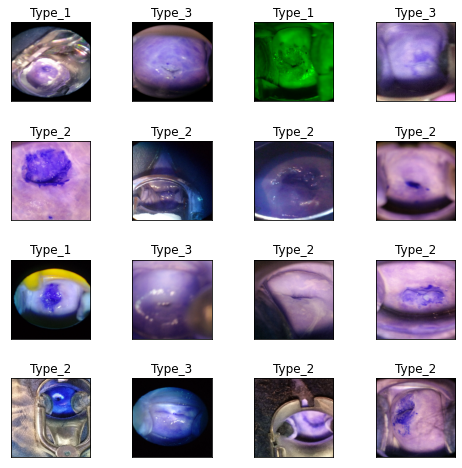

In [7]:
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [8]:
#encode text categories with labels
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 20
INPUT_SHAPE = (224, 224, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = to_categorical(train_labels_enc, num_classes=3)
val_labels_1hotenc = to_categorical(val_labels_enc, num_classes=3)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])


['Type_2' 'Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1'] [1 2 0 0 1 0]
['Type_2' 'Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1'] [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [9]:
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))



#scaling the test set and one-hot encoding the test labels
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

le = LabelEncoder()
le.fit(test_labels)
test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = to_categorical(test_labels_enc, num_classes=3)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

ThreadPoolExecutor-2_0: working on img num: 0


Premature end of JPEG file


ThreadPoolExecutor-2_7: working on img num: 444
['Type_2' 'Type_1' 'Type_2' 'Type_3' 'Type_1' 'Type_3'] [1 0 1 2 0 2]
['Type_2' 'Type_1' 'Type_2' 'Type_3' 'Type_1' 'Type_3'] [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


# VGG16 Model

In [10]:
vgg16Net = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg16Net.trainable = False
# Freeze the layers
for layer in vgg16Net.layers:
    layer.trainable = False
    
base_vgg16 = vgg16Net
base_out_vgg16 = base_vgg16.output
pool_out_vgg16 = tf.keras.layers.Flatten()(base_out_vgg16)
hidden1_vgg16 = tf.keras.layers.Dense(512, activation='relu')(pool_out_vgg16)
drop1_vgg16 = tf.keras.layers.Dropout(rate=0.3)(hidden1_vgg16)
hidden2_vgg16 = tf.keras.layers.Dense(512, activation='relu')(drop1_vgg16)
drop2_vgg16 = tf.keras.layers.Dropout(rate=0.3)(hidden2_vgg16)
out_vgg16 = tf.keras.layers.Dense(3, activation='softmax')(drop2_vgg16)

vgg16_model = tf.keras.Model(inputs=base_vgg16.input, outputs=out_vgg16)
vgg16_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
vgg16_model.summary()


2022-03-30 18:29:20.206636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 18:29:20.378657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 18:29:20.379406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 18:29:20.380397: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [11]:
vgg16_start = time.time()
vgg16_history = vgg16_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
vgg16_stop = time.time()


2022-03-30 18:29:23.463825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 561168384 exceeds 10% of free system memory.
2022-03-30 18:29:24.055594: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 561168384 exceeds 10% of free system memory.
2022-03-30 18:29:24.491734: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-30 18:29:26.027396: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


15/15 [==============================] - 20s 623ms/step - loss: 1.3626 - accuracy: 0.4539 - val_loss: 0.9404 - val_accuracy: 0.5865
Epoch 2/20
15/15 [==============================] - 2s 138ms/step - loss: 1.0073 - accuracy: 0.5139 - val_loss: 0.9633 - val_accuracy: 0.5769
Epoch 3/20
15/15 [==============================] - 2s 136ms/step - loss: 0.9861 - accuracy: 0.5300 - val_loss: 0.8986 - val_accuracy: 0.6250
Epoch 4/20
15/15 [==============================] - 2s 137ms/step - loss: 0.9634 - accuracy: 0.5547 - val_loss: 0.8880 - val_accuracy: 0.6058
Epoch 5/20
15/15 [==============================] - 2s 139ms/step - loss: 0.8934 - accuracy: 0.5901 - val_loss: 1.0295 - val_accuracy: 0.5769
Epoch 6/20
15/15 [==============================] - 2s 136ms/step - loss: 0.9191 - accuracy: 0.5837 - val_loss: 0.8420 - val_accuracy: 0.6058
Epoch 7/20
15/15 [==============================] - 2s 137ms/step - loss: 0.8776 - accuracy: 0.5740 - val_loss: 0.9862 - val_accuracy: 0.4519
Epoch 8/20
15/15

## VGG16 Summary

2022-03-30 18:30:24.777424: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 267939840 exceeds 10% of free system memory.
2022-03-30 18:30:25.060735: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 267939840 exceeds 10% of free system memory.


14/14 [==============================] - 7s 269ms/step - loss: 1.2561 - accuracy: 0.5056
+--------------------------------+--------+
|             VGG16              |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 80.26  |
|       Test Accuracy in %       | 50.56  |
|         Test Loss in %         | 125.61 |
| Time Taken To Train in Seconds | 60.28  |
+--------------------------------+--------+


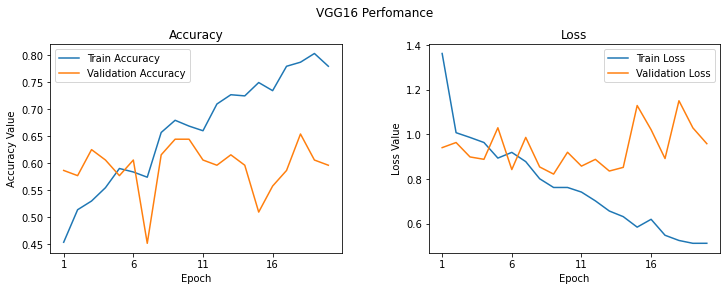

In [12]:
vgg16_trainTime=vgg16_stop-vgg16_start
vgg16_model_accuracy = vgg16_history.history['accuracy'][np.argmin(vgg16_history.history['loss'])]
vgg16_model_score=vgg16_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
vgg16_Summary = PrettyTable(["VGG16"," "])
vgg16_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(vgg16_model_accuracy*100)])
vgg16_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(vgg16_model_score[1]*100)])
vgg16_Summary.add_row(["Test Loss in %", "{:.2f}".format(vgg16_model_score[0]*100)])
vgg16_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(vgg16_trainTime)])
print(vgg16_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(vgg16_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, vgg16_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, vgg16_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, vgg16_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, vgg16_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## **VGG19**

In [13]:
#using VGG19 pre-trained model
vgg19Net = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg19Net.trainable = False
# Freeze the layers
for layer in vgg16Net.layers:
    layer.trainable = False
    
base_vgg19 = vgg16Net
base_out_vgg19= base_vgg19.output
pool_out_vgg19 = tf.keras.layers.Flatten()(base_out_vgg19)
hidden1_vgg19 = tf.keras.layers.Dense(512, activation='relu')(pool_out_vgg19)
drop1_vgg19 = tf.keras.layers.Dropout(rate=0.3)(hidden1_vgg19)
hidden2_vgg19 = tf.keras.layers.Dense(512, activation='relu')(drop1_vgg19)
drop2_vgg19 = tf.keras.layers.Dropout(rate=0.3)(hidden2_vgg19)
out_vgg19 = tf.keras.layers.Dense(3, activation='softmax')(drop2_vgg19)

vgg19_model = tf.keras.Model(inputs=base_vgg19.input, outputs=out_vgg19)
vgg19_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
vgg19_model.summary()


80150528/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [14]:
vgg19_start = time.time()
vgg19_history = vgg19_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
vgg19_stop = time.time()

2022-03-30 18:30:37.616397: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 561168384 exceeds 10% of free system memory.


Epoch 1/20
15/15 [==============================] - 3s 161ms/step - loss: 1.3669 - accuracy: 0.4292 - val_loss: 0.9409 - val_accuracy: 0.5865
Epoch 2/20
15/15 [==============================] - 2s 137ms/step - loss: 1.0209 - accuracy: 0.5118 - val_loss: 0.9939 - val_accuracy: 0.4712
Epoch 3/20
15/15 [==============================] - 2s 136ms/step - loss: 1.0219 - accuracy: 0.5021 - val_loss: 0.9464 - val_accuracy: 0.5962
Epoch 4/20
15/15 [==============================] - 2s 139ms/step - loss: 0.9319 - accuracy: 0.5590 - val_loss: 1.0399 - val_accuracy: 0.5865
Epoch 5/20
15/15 [==============================] - 2s 137ms/step - loss: 0.9366 - accuracy: 0.5601 - val_loss: 0.9891 - val_accuracy: 0.5000
Epoch 6/20
15/15 [==============================] - 2s 136ms/step - loss: 0.8828 - accuracy: 0.5858 - val_loss: 0.8848 - val_accuracy: 0.6442
Epoch 7/20
15/15 [==============================] - 2s 135ms/step - loss: 0.8332 - accuracy: 0.6255 - val_loss: 0.9040 - val_accuracy: 0.5481
Epoch 

## VGG19 Summary

14/14 [==============================] - 1s 63ms/step - loss: 1.3058 - accuracy: 0.5213
+--------------------------------+--------+
|             Vgg19              |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 83.15  |
|       Test Accuracy in %       | 52.13  |
|         Test Loss in %         | 130.58 |
| Time Taken To Train in Seconds | 43.04  |
+--------------------------------+--------+


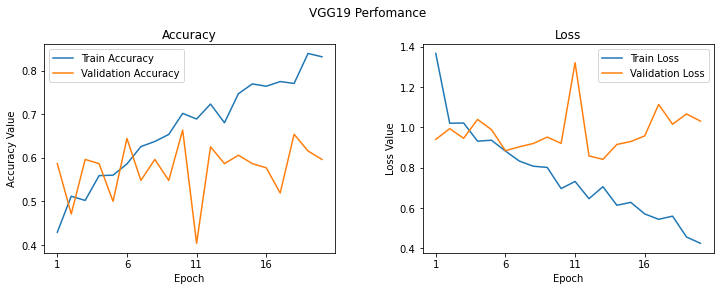

In [15]:
vgg19_trainTime=vgg19_stop-vgg19_start
vgg19_model_accuracy = vgg19_history.history['accuracy'][np.argmin(vgg19_history.history['loss'])]
vgg19_model_score=vgg19_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
vgg19_Summary = PrettyTable(["Vgg19"," "])
vgg19_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(vgg19_model_accuracy*100)])
vgg19_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(vgg19_model_score[1]*100)])
vgg19_Summary.add_row(["Test Loss in %", "{:.2f}".format(vgg19_model_score[0]*100)])
vgg19_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(vgg19_trainTime)])
print(vgg19_Summary)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG19 Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(vgg19_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, vgg19_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, vgg19_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, vgg19_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, vgg19_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Xception

In [16]:
#using Xception trained model
Xception = tf.keras.applications.Xception(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
Xception.trainable = False
# Freeze the layers
for layer in Xception.layers:
    layer.trainable = False
    
base_Xception = Xception
base_out_Xception = base_Xception.output
pool_out_Xception = tf.keras.layers.Flatten()(base_out_Xception)
hidden1_Xception = tf.keras.layers.Dense(512, activation='relu')(pool_out_Xception)
drop1_Xception = tf.keras.layers.Dropout(rate=0.3)(hidden1_Xception)
hidden2_Xception = tf.keras.layers.Dense(512, activation='relu')(drop1_Xception)
drop2_Xception = tf.keras.layers.Dropout(rate=0.3)(hidden2_Xception)
out_Xception = tf.keras.layers.Dense(3, activation='softmax')(drop2_Xception)

Xception_model = tf.keras.Model(inputs=base_Xception.input, outputs=out_Xception)
Xception_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
Xception.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [17]:
Xception_start = time.time()
Xception_history = Xception_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
Xception_stop = time.time()


Epoch 1/20
15/15 [==============================] - 7s 278ms/step - loss: 3.4554 - accuracy: 0.3863 - val_loss: 1.3549 - val_accuracy: 0.3846
Epoch 2/20
15/15 [==============================] - 3s 177ms/step - loss: 1.2969 - accuracy: 0.4785 - val_loss: 1.1561 - val_accuracy: 0.4327
Epoch 3/20
15/15 [==============================] - 3s 180ms/step - loss: 1.1181 - accuracy: 0.5172 - val_loss: 1.4072 - val_accuracy: 0.2308
Epoch 4/20
15/15 [==============================] - 3s 182ms/step - loss: 0.9979 - accuracy: 0.5397 - val_loss: 1.1101 - val_accuracy: 0.5481
Epoch 5/20
15/15 [==============================] - 3s 178ms/step - loss: 0.8939 - accuracy: 0.6084 - val_loss: 1.3346 - val_accuracy: 0.4712
Epoch 6/20
15/15 [==============================] - 3s 178ms/step - loss: 0.8423 - accuracy: 0.6352 - val_loss: 0.9703 - val_accuracy: 0.5577
Epoch 7/20
15/15 [==============================] - 3s 177ms/step - loss: 0.8066 - accuracy: 0.6502 - val_loss: 1.1988 - val_accuracy: 0.5385
Epoch 

## Xception Summary

14/14 [==============================] - 2s 98ms/step - loss: 1.8506 - accuracy: 0.4202
+--------------------------------+--------+
|            Xception            |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 93.99  |
|       Test Accuracy in %       | 42.02  |
|         Test Loss in %         | 185.06 |
| Time Taken To Train in Seconds | 58.88  |
+--------------------------------+--------+


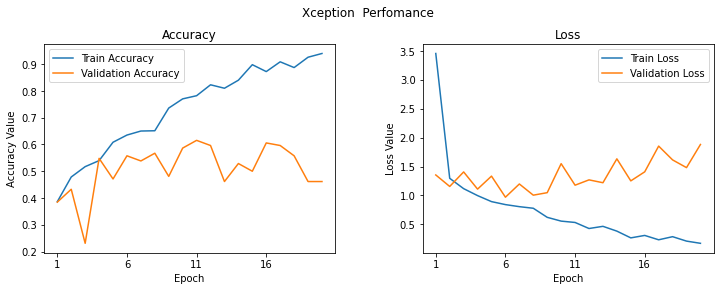

In [18]:
Xception_trainTime=Xception_stop-Xception_start
Xception_model_accuracy = Xception_history.history['accuracy'][np.argmin(Xception_history.history['loss'])]
Xception_model_score=Xception_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
Xception_Summary = PrettyTable(["Xception"," "])
Xception_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(Xception_model_accuracy*100)])
Xception_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(Xception_model_score[1]*100)])
Xception_Summary.add_row(["Test Loss in %", "{:.2f}".format(Xception_model_score[0]*100)])
Xception_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(Xception_trainTime)])
print(Xception_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Xception  Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(Xception_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, Xception_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, Xception_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, Xception_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, Xception_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# ResNet 

In [19]:
#using ResNet trained model
ResNet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
ResNet.trainable = False
# Freeze the layers
for layer in ResNet.layers:
    layer.trainable = False
    
base_ResNet = ResNet
base_out_ResNet = base_ResNet.output
pool_out_ResNet = tf.keras.layers.Flatten()(base_out_ResNet)
hidden1_ResNet = tf.keras.layers.Dense(512, activation='relu')(pool_out_ResNet)
drop1_ResNet = tf.keras.layers.Dropout(rate=0.3)(hidden1_ResNet)
hidden2_ResNet = tf.keras.layers.Dense(512, activation='relu')(drop1_ResNet)
drop2_ResNet = tf.keras.layers.Dropout(rate=0.3)(hidden2_ResNet)
out_ResNet = tf.keras.layers.Dense(3, activation='softmax')(drop2_ResNet)

ResNet_model = tf.keras.Model(inputs=base_ResNet.input, outputs=out_ResNet)
ResNet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
ResNet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [20]:
ResNet_start = time.time()
ResNet_history = ResNet_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
ResNet_stop = time.time()

Epoch 1/20
15/15 [==============================] - 6s 232ms/step - loss: 2.1915 - accuracy: 0.4045 - val_loss: 1.0141 - val_accuracy: 0.3846
Epoch 2/20
15/15 [==============================] - 2s 131ms/step - loss: 1.1572 - accuracy: 0.4603 - val_loss: 0.9622 - val_accuracy: 0.5865
Epoch 3/20
15/15 [==============================] - 2s 131ms/step - loss: 1.0518 - accuracy: 0.4753 - val_loss: 0.9680 - val_accuracy: 0.5865
Epoch 4/20
15/15 [==============================] - 2s 141ms/step - loss: 1.0265 - accuracy: 0.4936 - val_loss: 0.9793 - val_accuracy: 0.5865
Epoch 5/20
15/15 [==============================] - 2s 131ms/step - loss: 1.0299 - accuracy: 0.4946 - val_loss: 0.9513 - val_accuracy: 0.5865
Epoch 6/20
15/15 [==============================] - 2s 130ms/step - loss: 1.0343 - accuracy: 0.5011 - val_loss: 0.9633 - val_accuracy: 0.5865
Epoch 7/20
15/15 [==============================] - 2s 130ms/step - loss: 1.0342 - accuracy: 0.5011 - val_loss: 0.9732 - val_accuracy: 0.5865
Epoch 

## ResNet Summary

14/14 [==============================] - 1s 75ms/step - loss: 1.0165 - accuracy: 0.5079
+--------------------------------+--------+
|             ResNet             |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 53.22  |
|       Test Accuracy in %       | 50.79  |
|         Test Loss in %         | 101.65 |
| Time Taken To Train in Seconds | 85.56  |
+--------------------------------+--------+


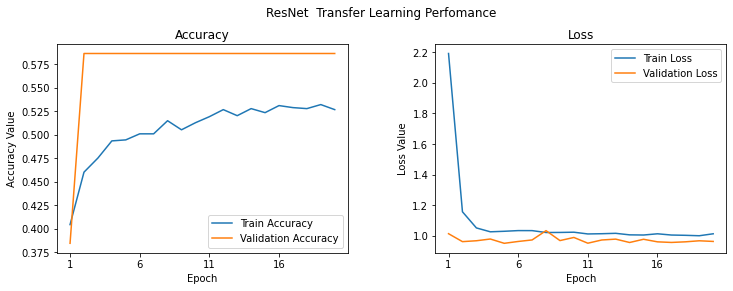

In [21]:
ResNet_trainTime=ResNet_stop-ResNet_start
ResNet_model_accuracy = ResNet_history.history['accuracy'][np.argmin(ResNet_history.history['loss'])]
ResNet_model_score=ResNet_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
ResNet_Summary = PrettyTable(["ResNet"," "])
ResNet_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(ResNet_model_accuracy*100)])
ResNet_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(ResNet_model_score[1]*100)])
ResNet_Summary.add_row(["Test Loss in %", "{:.2f}".format(ResNet_model_score[0]*100)])
ResNet_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(ResNet_trainTime)])
print(ResNet_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet  Transfer Learning Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(ResNet_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, ResNet_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, ResNet_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, ResNet_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, ResNet_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# InceptionV3

In [22]:
#using InceptionV3 trained model
InceptionV3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
InceptionV3.trainable = False
# Freeze the layers
for layer in InceptionV3.layers:
    layer.trainable = False
    
base_InceptionV3 = InceptionV3
base_out_InceptionV3 = base_InceptionV3.output
pool_out_InceptionV3 = tf.keras.layers.Flatten()(base_out_InceptionV3)
hidden1_InceptionV3 = tf.keras.layers.Dense(512, activation='relu')(pool_out_InceptionV3)
drop1_InceptionV3 = tf.keras.layers.Dropout(rate=0.3)(hidden1_InceptionV3)
hidden2_InceptionV3 = tf.keras.layers.Dense(512, activation='relu')(drop1_InceptionV3)
drop2_InceptionV3 = tf.keras.layers.Dropout(rate=0.3)(hidden2_InceptionV3)
out_InceptionV3 = tf.keras.layers.Dense(3, activation='softmax')(drop2_InceptionV3)

InceptionV3_model = tf.keras.Model(inputs=base_InceptionV3.input, outputs=out_InceptionV3)
InceptionV3_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
InceptionV3.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 111, 111, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_4[0][0]      
______________________

In [23]:
InceptionV3_start = time.time()
InceptionV3_history = InceptionV3_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
InceptionV3_stop = time.time()

Epoch 1/20
15/15 [==============================] - 7s 247ms/step - loss: 4.2617 - accuracy: 0.4292 - val_loss: 0.9352 - val_accuracy: 0.5962
Epoch 2/20
15/15 [==============================] - 1s 99ms/step - loss: 1.3140 - accuracy: 0.4624 - val_loss: 0.9741 - val_accuracy: 0.5481
Epoch 3/20
15/15 [==============================] - 1s 100ms/step - loss: 1.0630 - accuracy: 0.5386 - val_loss: 0.9066 - val_accuracy: 0.6058
Epoch 4/20
15/15 [==============================] - 1s 100ms/step - loss: 1.0550 - accuracy: 0.4957 - val_loss: 0.9182 - val_accuracy: 0.5577
Epoch 5/20
15/15 [==============================] - 2s 109ms/step - loss: 0.9805 - accuracy: 0.5472 - val_loss: 1.0451 - val_accuracy: 0.5865
Epoch 6/20
15/15 [==============================] - 2s 104ms/step - loss: 0.9752 - accuracy: 0.5536 - val_loss: 0.9359 - val_accuracy: 0.6058
Epoch 7/20
15/15 [==============================] - 2s 102ms/step - loss: 0.8664 - accuracy: 0.6191 - val_loss: 1.3171 - val_accuracy: 0.3846
Epoch 8

## InceptionV3 Summary

14/14 [==============================] - 1s 82ms/step - loss: 2.5010 - accuracy: 0.4337
+--------------------------------+--------+
|          InceptionV3           |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 90.99  |
|       Test Accuracy in %       | 43.37  |
|         Test Loss in %         | 250.10 |
| Time Taken To Train in Seconds | 45.23  |
+--------------------------------+--------+


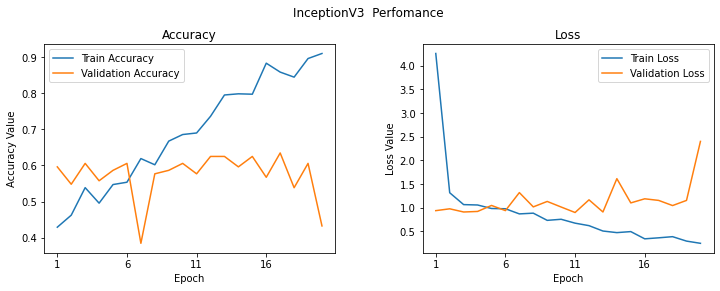

In [24]:
InceptionV3_trainTime=InceptionV3_stop-InceptionV3_start
InceptionV3_model_accuracy = InceptionV3_history.history['accuracy'][np.argmin(InceptionV3_history.history['loss'])]
InceptionV3_model_score=InceptionV3_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
InceptionV3_Summary = PrettyTable(["InceptionV3"," "])
InceptionV3_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(InceptionV3_model_accuracy*100)])
InceptionV3_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(InceptionV3_model_score[1]*100)])
InceptionV3_Summary.add_row(["Test Loss in %", "{:.2f}".format(InceptionV3_model_score[0]*100)])
InceptionV3_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(InceptionV3_trainTime)])
print(InceptionV3_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('InceptionV3  Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(InceptionV3_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, InceptionV3_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, InceptionV3_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, InceptionV3_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, InceptionV3_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# MobileNet

In [25]:
#using InceptionV3 trained model
MobileNet = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
MobileNet.trainable = False
# Freeze the layers
for layer in MobileNet.layers:
    layer.trainable = False
    
base_MobileNet = MobileNet
base_out_MobileNet = base_MobileNet.output
pool_out_MobileNet = tf.keras.layers.Flatten()(base_out_MobileNet)
hidden1_MobileNet = tf.keras.layers.Dense(512, activation='relu')(pool_out_MobileNet)
drop1_MobileNet = tf.keras.layers.Dropout(rate=0.3)(hidden1_MobileNet)
hidden2_MobileNet = tf.keras.layers.Dense(512, activation='relu')(drop1_MobileNet)
drop2_MobileNet = tf.keras.layers.Dropout(rate=0.3)(hidden2_MobileNet)
out_MobileNet = tf.keras.layers.Dense(3, activation='softmax')(drop2_MobileNet)

MobileNet_model = tf.keras.Model(inputs=base_MobileNet.input, outputs=out_MobileNet)
MobileNet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
MobileNet.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

In [26]:
MobileNet_start = time.time()
MobileNet_history = MobileNet_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
MobileNet_stop = time.time()


Epoch 1/20
15/15 [==============================] - 4s 134ms/step - loss: 3.7199 - accuracy: 0.4174 - val_loss: 1.1087 - val_accuracy: 0.4038
Epoch 2/20
15/15 [==============================] - 1s 63ms/step - loss: 1.2557 - accuracy: 0.5204 - val_loss: 1.0143 - val_accuracy: 0.6058
Epoch 3/20
15/15 [==============================] - 1s 65ms/step - loss: 0.9441 - accuracy: 0.6073 - val_loss: 1.1091 - val_accuracy: 0.5096
Epoch 4/20
15/15 [==============================] - 1s 65ms/step - loss: 0.7718 - accuracy: 0.6824 - val_loss: 0.8864 - val_accuracy: 0.5673
Epoch 5/20
15/15 [==============================] - 1s 65ms/step - loss: 0.5386 - accuracy: 0.7854 - val_loss: 0.9933 - val_accuracy: 0.4808
Epoch 6/20
15/15 [==============================] - 1s 65ms/step - loss: 0.7196 - accuracy: 0.7554 - val_loss: 1.5112 - val_accuracy: 0.4231
Epoch 7/20
15/15 [==============================] - 1s 67ms/step - loss: 0.3581 - accuracy: 0.8530 - val_loss: 0.9143 - val_accuracy: 0.5192
Epoch 8/20
1

## MobileNet Summary

14/14 [==============================] - 1s 34ms/step - loss: 2.3188 - accuracy: 0.5371
+--------------------------------+--------+
|           MobileNet            |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 99.57  |
|       Test Accuracy in %       | 53.71  |
|         Test Loss in %         | 231.88 |
| Time Taken To Train in Seconds | 23.37  |
+--------------------------------+--------+


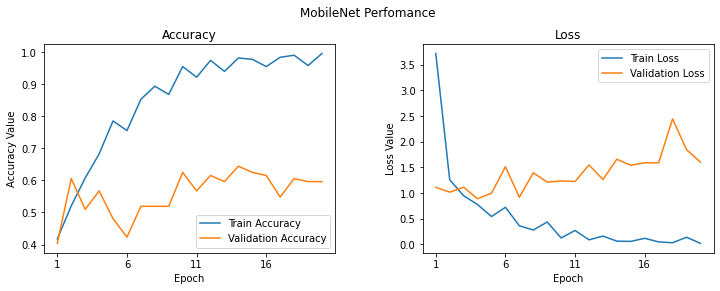

In [27]:
MobileNet_trainTime=MobileNet_stop-MobileNet_start
MobileNet_model_accuracy = MobileNet_history.history['accuracy'][np.argmin(MobileNet_history.history['loss'])]
MobileNet_model_score=MobileNet_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
MobileNet_Summary = PrettyTable(["MobileNet"," "])
MobileNet_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(MobileNet_model_accuracy*100)])
MobileNet_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(MobileNet_model_score[1]*100)])
MobileNet_Summary.add_row(["Test Loss in %", "{:.2f}".format(MobileNet_model_score[0]*100)])
MobileNet_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(MobileNet_trainTime)])
print(MobileNet_Summary)

####graph

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MobileNet Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(MobileNet_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, MobileNet_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, MobileNet_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, MobileNet_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, MobileNet_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Summary

+-------------+---------------------------+--------------------------+--------------------------------+
|  Model Name | Model Train Accuracy in % | Model Test Accuracy in % | Time Taken To Train in Seconds |
+-------------+---------------------------+--------------------------+--------------------------------+
|    Vgg16    |           80.26           |          50.56           |             60.28              |
|    Vgg19    |           83.15           |          52.13           |             43.04              |
|   Xception  |           93.99           |          42.02           |             58.88              |
|    ResNet   |           53.22           |          50.79           |             85.56              |
| InceptionV3 |           90.99           |          43.37           |             45.23              |
|  MobileNet  |           99.57           |          53.71           |             23.37              |
+-------------+---------------------------+---------------------

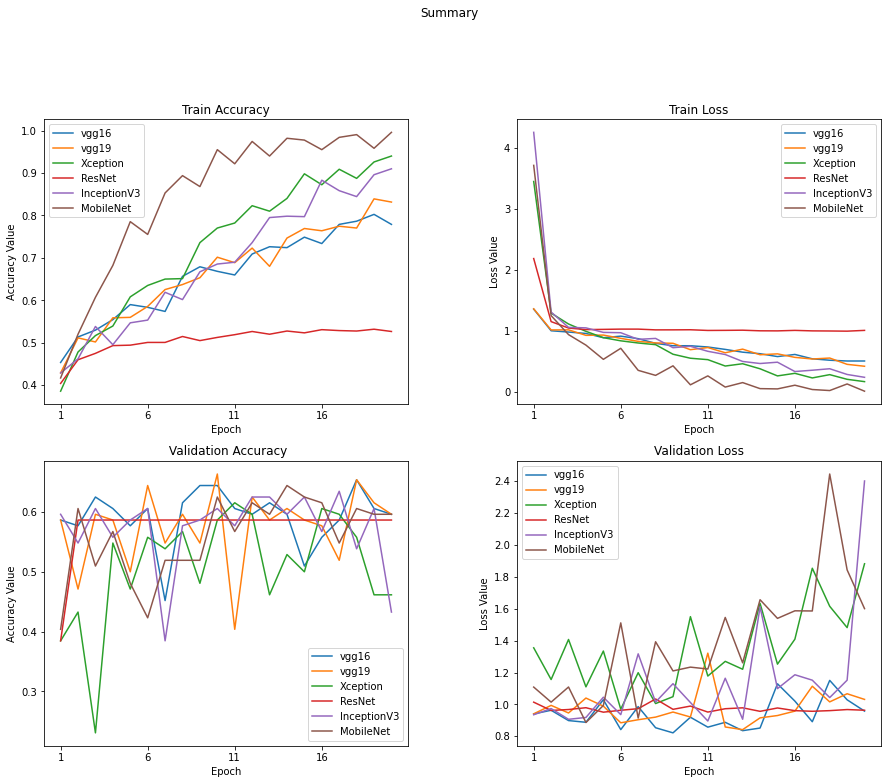

In [28]:
Summary = PrettyTable(["Model Name", "Model Train Accuracy in %", "Model Test Accuracy in %","Time Taken To Train in Seconds"])
Summary.add_row(["Vgg16", "{:.2f}".format(vgg16_model_accuracy*100),"{:.2f}".format(vgg16_model_score[1]*100),"{:.2f}".format(vgg16_trainTime)])
Summary.add_row(["Vgg19", "{:.2f}".format(vgg19_model_accuracy*100),"{:.2f}".format(vgg19_model_score[1]*100),"{:.2f}".format(vgg19_trainTime)])
Summary.add_row(["Xception", "{:.2f}".format(Xception_model_accuracy*100),"{:.2f}".format(Xception_model_score[1]*100),"{:.2f}".format(Xception_trainTime)])
Summary.add_row(["ResNet", "{:.2f}".format(ResNet_model_accuracy*100),"{:.2f}".format(ResNet_model_score[1]*100),"{:.2f}".format(ResNet_trainTime)])
Summary.add_row(["InceptionV3", "{:.2f}".format(InceptionV3_model_accuracy*100),"{:.2f}".format(InceptionV3_model_score[1]*100),"{:.2f}".format(InceptionV3_trainTime)])
Summary.add_row(["MobileNet", "{:.2f}".format(MobileNet_model_accuracy*100),"{:.2f}".format(MobileNet_model_score[1]*100),"{:.2f}".format(MobileNet_trainTime)])

print(Summary)
f, ax = plt.subplots(2, 2, figsize=(15, 12))
t = f.suptitle('Summary', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = list(range(1,21))


ax[0,0].plot(epoch_list, vgg16_history.history['accuracy'], label='vgg16')
ax[0,0].plot(epoch_list, vgg19_history.history['accuracy'], label='vgg19')
ax[0,0].plot(epoch_list, Xception_history.history['accuracy'], label='Xception')
ax[0,0].plot(epoch_list, ResNet_history.history['accuracy'], label='ResNet')
ax[0,0].plot(epoch_list, InceptionV3_history.history['accuracy'], label='InceptionV3')
ax[0,0].plot(epoch_list, MobileNet_history.history['accuracy'], label='MobileNet')
ax[0,0].set_xticks(np.arange(1, max_epoch, 5))
ax[0,0].set_ylabel('Accuracy Value')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_title('Train Accuracy')
l1 = ax[0,0].legend(loc="best")


ax[0,1].plot(epoch_list, vgg16_history.history['loss'], label='vgg16')
ax[0,1].plot(epoch_list, vgg19_history.history['loss'], label='vgg19')
ax[0,1].plot(epoch_list, Xception_history.history['loss'], label='Xception')
ax[0,1].plot(epoch_list, ResNet_history.history['loss'], label='ResNet')
ax[0,1].plot(epoch_list, InceptionV3_history.history['loss'], label='InceptionV3')
ax[0,1].plot(epoch_list, MobileNet_history.history['loss'], label='MobileNet')
ax[0,1].set_xticks(np.arange(1, max_epoch, 5))
ax[0,1].set_ylabel('Loss Value')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_title('Train Loss')
l2 = ax[0,1].legend(loc="best")

ax[1,0].plot(epoch_list, vgg16_history.history['val_accuracy'], label='vgg16')
ax[1,0].plot(epoch_list, vgg19_history.history['val_accuracy'], label='vgg19')
ax[1,0].plot(epoch_list, Xception_history.history['val_accuracy'], label='Xception')
ax[1,0].plot(epoch_list, ResNet_history.history['val_accuracy'], label='ResNet')
ax[1,0].plot(epoch_list, InceptionV3_history.history['val_accuracy'], label='InceptionV3')
ax[1,0].plot(epoch_list, MobileNet_history.history['val_accuracy'], label='MobileNet')
ax[1,0].set_xticks(np.arange(1, max_epoch, 5))
ax[1,0].set_ylabel('Accuracy Value')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_title(' Validation Accuracy')
l3 = ax[1,0].legend(loc="best")


ax[1,1].plot(epoch_list, vgg16_history.history['val_loss'], label='vgg16')
ax[1,1].plot(epoch_list, vgg19_history.history['val_loss'], label='vgg19')
ax[1,1].plot(epoch_list, Xception_history.history['val_loss'], label='Xception')
ax[1,1].plot(epoch_list, ResNet_history.history['val_loss'], label='ResNet')
ax[1,1].plot(epoch_list, InceptionV3_history.history['val_loss'], label='InceptionV3')
ax[1,1].plot(epoch_list, MobileNet_history.history['val_loss'], label='MobileNet')
ax[1,1].set_xticks(np.arange(1, max_epoch, 5))
ax[1,1].set_ylabel('Loss Value')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_title('Validation Loss')
l4 = ax[1,1].legend(loc="best")

# Prediction of Given Image

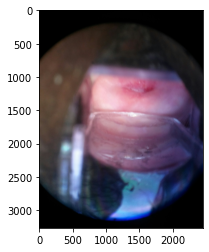

ThreadPoolExecutor-2_5: working on img num: 0
######Generate a vgg16 prediction########
Test image is Classified as Type 2 with 68.74% in vgg16
                                                                 
######Generate a vgg19 prediction########
Test image is Classified as Type 2 with 67.20% in vgg19
                                                                 
######Generate a Xception  prediction########
Test image is Classified as Type 3 with 58.65% in Xception
                                                                 
######Generate a ResNet prediction########
Test image is Classified as Type 2 with 49.61% in ResNet
                                                                 
######Generate a InceptionV3  prediction########
Test image is Classified as Type 3 with 98.17% in InceptionV3
                                                                 
######Generate a MobileNet prediction########
Test image is Classified as Type 2 with 86.26% in MobileNet


In [29]:
from matplotlib import pyplot
img='../input/intel-mobileodt-cervical-cancer-screening/test/test/1.jpg'
data = pyplot.imread(img)
pyplot.imshow(data)
ax = pyplot.gca()
pyplot.show()


test1_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate([img])]
test1_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test1_data_inp],
                        [record[1] for record in test1_data_inp],
                        [record[2] for record in test1_data_inp])
test1_data = np.array(list(test1_data_map))
test1_imgs_scaled = test1_data / 255.

print("######Generate a vgg16 prediction########")
vgg16_prediction = vgg16_model.predict(test1_imgs_scaled)

if (vgg16_prediction[0][0] >= vgg16_prediction[0][1]) and (vgg16_prediction[0][0] >= vgg16_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in vgg16".format(vgg16_prediction[0][0]*100))
elif (vgg16_prediction[0][1] >= vgg16_prediction[0][0]) and (vgg16_prediction[0][1] >= vgg16_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in vgg16".format(vgg16_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in vgg16".format(vgg16_prediction[0][2]*100))
    
print("                                                                 ")    
print("######Generate a vgg19 prediction########")
vgg19_prediction = vgg19_model.predict(test1_imgs_scaled)

if (vgg19_prediction[0][0] >= vgg19_prediction[0][1]) and (vgg19_prediction[0][0] >= vgg19_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in vgg19".format(vgg19_prediction[0][0]*100))
elif (vgg19_prediction[0][1] >= vgg19_prediction[0][0]) and (vgg19_prediction[0][1] >= vgg19_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in vgg19".format(vgg19_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in vgg19".format(vgg19_prediction[0][2]*100))
    
    
print("                                                                 ")    
print("######Generate a Xception  prediction########")
Xception_prediction = Xception_model.predict(test1_imgs_scaled)

if (Xception_prediction[0][0] >= Xception_prediction[0][1]) and (Xception_prediction[0][0] >= Xception_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in Xception".format(Xception_prediction[0][0]*100))
elif (Xception_prediction[0][1] >= Xception_prediction[0][0]) and (Xception_prediction[0][1] >= Xception_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in Xception".format(Xception_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in Xception".format(Xception_prediction[0][2]*100))
    
print("                                                                 ")    
print("######Generate a ResNet prediction########")
ResNet_prediction = ResNet_model.predict(test1_imgs_scaled)

if (ResNet_prediction[0][0] >= ResNet_prediction[0][1]) and (ResNet_prediction[0][0] >= ResNet_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in ResNet".format(ResNet_prediction[0][0]*100))
elif (ResNet_prediction[0][1] >= ResNet_prediction[0][0]) and (ResNet_prediction[0][1] >= ResNet_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in ResNet".format(ResNet_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in ResNet".format(ResNet_prediction[0][2]*100))
    
print("                                                                 ")    
print("######Generate a InceptionV3  prediction########")
InceptionV3_prediction = InceptionV3_model.predict(test1_imgs_scaled)

if (InceptionV3_prediction[0][0] >= InceptionV3_prediction[0][1]) and (InceptionV3_prediction[0][0] >= InceptionV3_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in InceptionV3 ".format(InceptionV3_prediction[0][0]*100))
elif (InceptionV3_prediction[0][1] >= vgg19_prediction[0][0]) and (InceptionV3_prediction[0][1] >= InceptionV3_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in InceptionV3".format(InceptionV3_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in InceptionV3".format(InceptionV3_prediction[0][2]*100))
    
    
print("                                                                 ")    
print("######Generate a MobileNet prediction########")
MobileNet_prediction = MobileNet_model.predict(test1_imgs_scaled)

if (MobileNet_prediction[0][0] >= MobileNet_prediction[0][1]) and (MobileNet_prediction[0][0] >= MobileNet_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in MobileNet".format(MobileNet_prediction[0][0]*100))
elif (MobileNet_prediction[0][1] >= MobileNet_prediction[0][0]) and (MobileNet_prediction[0][1] >= MobileNet_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in MobileNet".format(MobileNet_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in MobileNet".format(MobileNet_prediction[0][2]*100))
 